pip install collection
pip install os.path
pip install matplotlib
pip install seaborn
pip install numpy
pip install pandas
pip install sklearn 
pip install scipy
pip install IPython
pip install yellowbrick

#instal sompy
!conda install git
!pip install -U git+https://github.com/joaopfonseca/SOMPY.git

# Perspective:Demographic 

In [44]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster.elbow import KElbowVisualizer
from sklearn.mixture import GaussianMixture
from IPython.display import YouTubeVideo
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

# 1.Functions

In [45]:
def number_clusters(df,cluster_model):
    metrics=['silhouette','distortion','calinski_harabasz']
    model=cluster_model
    for score in metrics:
        plt.figure()
        plt.ylabel(score)
        plt.xlabel('Number of clusters')
        Visualizer=KElbowVisualizer(model,metric=score).fit(df)
        plt.show

In [46]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [47]:
def gmm_config(data,limit_nrcomponents):
    bic_values =[]
    aic_values =[]
    types_covariance=['full','diag','spherical']
    for i in types_covariance:
        n_components = np.arange(1, limit_nrcomponents)
        models = [GaussianMixture(n, covariance_type=i, n_init=10, random_state=1).fit(data)
                  for n in n_components]
        bic_values.append([m.bic(data) for m in models])
        aic_values.append([m.aic(data) for m in models])
    #barplot for BIC
    bic=plt.figure(1)
    X = np.arange(1,limit_nrcomponents)
    plt.bar(X + 0.00, bic_values[0], label='full' ,color = 'b', width = 0.3)
    plt.bar(X + 0.25, bic_values[1], label='diag',color = 'g', width = 0.3)
    plt.bar(X + 0.50, bic_values[2], label='spherical',color = 'r', width = 0.3)
    plt.xlabel('number of components')
    plt.ylabel('BIC')
    plt.legend(loc='best')
   #barplot for AIC
    aic=plt.figure(2)
    X = np.arange(1,limit_nrcomponents)
    plt.bar(X + 0.00, aic_values[0], label='full' ,color = 'b', width = 0.3)
    plt.bar(X + 0.25, aic_values[1], label='diag',color = 'g', width = 0.3)
    plt.bar(X + 0.50, aic_values[2], label='spherical',color = 'r', width = 0.3)
    plt.xlabel('number of components')
    plt.ylabel('AIC')
    plt.legend(loc='best')
    bic.show
    aic.show

In [48]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) #get cluster labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

In [49]:
#on 'type_covariance'-you have to insert with '', for example 'full'
def gmm_components(data,type_covariance,min_components,max_components):
    # Selecting number of components based on AIC and BIC
    n_components = np.arange(min_components,max_components)
    models = [GaussianMixture(n, covariance_type=type_covariance, n_init=10, random_state=1).fit(data)
              for n in n_components]

    bic_values = [m.bic(data) for m in models]
    aic_values = [m.aic(data) for m in models]
    plt.plot(n_components, bic_values, label='BIC')
    plt.plot(n_components, aic_values, label='AIC')
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.xticks(n_components)
    plt.show()

# 2.Dataset

In [50]:
pva_i = pd.read_csv('pva_i_ohe_out.csv', sep=';')
pva_i.head()

,TCODE,Age,NUMCHLD,INCOME,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,MDMAUD_A_0,MDMAUD_A_C,MDMAUD_A_L,MDMAUD_A_M,MDMAUD_A_T,GEOCODE2_,GEOCODE2_A,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D
0,-0.056847,0.039357,-0.336116,-0.265780,-0.356881,-0.206977,0.745798,0.284659,-0.826571,0.719013,...,1,0,0,0,0,0,0,0,1,0
1,-0.055799,0.061957,-0.336116,-0.477775,-0.141985,-0.206977,-0.910626,-0.046518,0.020458,-0.191801,...,1,0,0,0,0,0,0,0,1,0
2,-0.056847,0.637259,-0.336116,-1.555973,-0.141985,-0.206977,-0.649086,-1.040049,-0.092480,-0.874911,...,1,0,0,0,0,0,0,0,1,0
3,-0.056847,-0.240152,-0.336116,-0.051029,-0.356881,-0.206977,-0.387545,0.417130,-0.544228,0.035903,...,1,0,0,0,0,0,0,0,1,0
4,-0.056847,-1.276027,1.358619,0.061324,-0.356881,-0.206977,0.222716,0.417130,0.076926,0.035903,...,1,0,0,0,0,0,0,0,0,1


# 3.Choosing the variables 

In [51]:
DEMO =pva_i[['Age','GENDER_F','GENDER_M','GENDER_U','INCOME','NUMCHLD']]

In [52]:
DEMO.head()

,Age,GENDER_F,GENDER_M,GENDER_U,INCOME,NUMCHLD
0,0.039357,1,0,0,-0.265780,-0.336116
1,0.061957,0,1,0,-0.477775,-0.336116
2,0.637259,1,0,0,-1.555973,-0.336116
3,-0.240152,0,0,1,-0.051029,-0.336116
4,-1.276027,1,0,0,0.061324,1.358619


# 4.K Means 

### 4.1.K-elbow plots

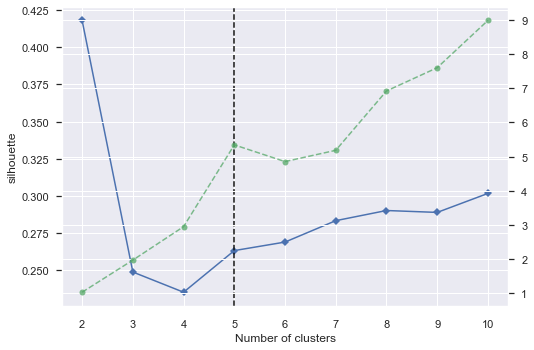

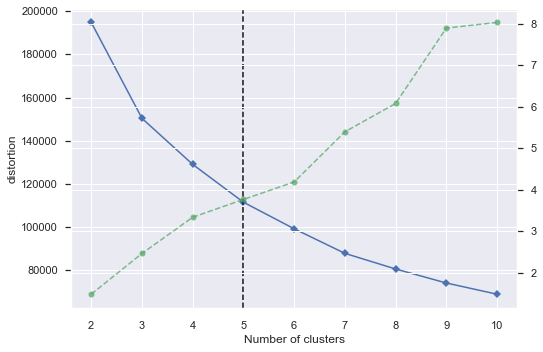

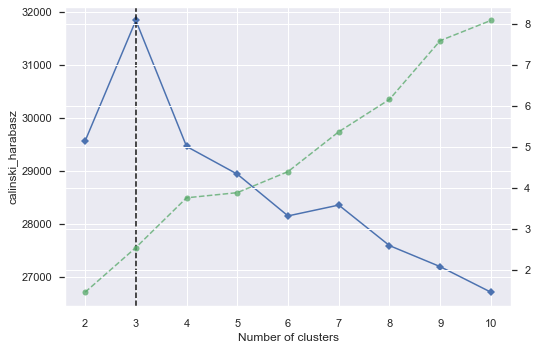

In [53]:
number_clusters(DEMO,KMeans( init='k-means++', n_init=15, random_state=1))

#### 4.2.Silhouette Analysis

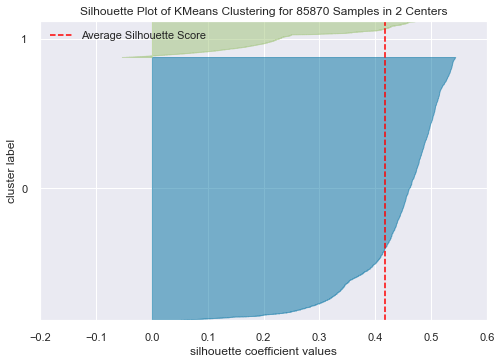

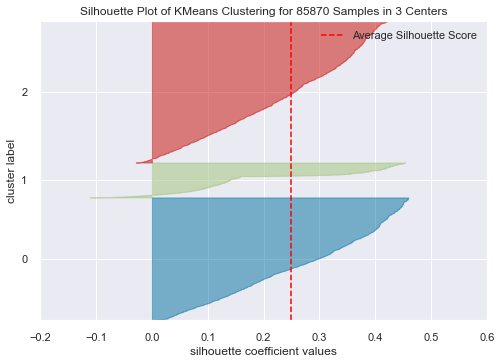

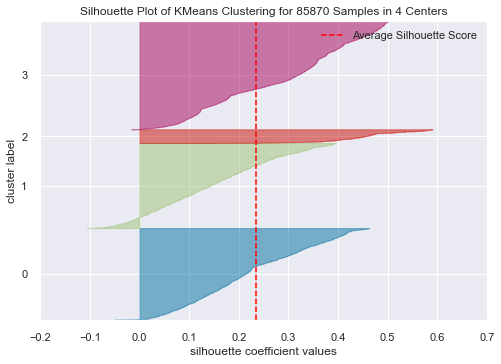

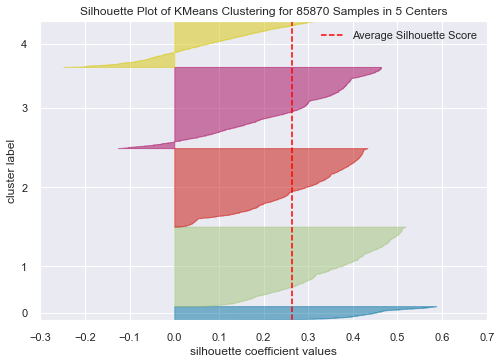

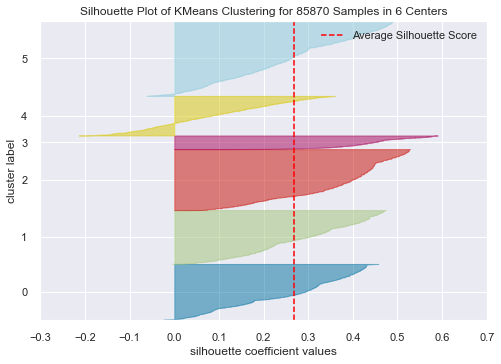

[<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 85870 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
 <AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 85870 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
 <AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 85870 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
 <AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 85870 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
 <AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 85870 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>]

In [54]:
[SilhouetteVisualizer(KMeans(n_clusters=i,init='k-means++', n_init=15, random_state=1), colors='yellowbrick').fit(DEMO).show() for i in range(2,7)]

### 4.3.Applying the clustering

In [33]:
#According to the KElbowVisualizer and the SilhouetteVisualizer we were able to determine that the optimal number of clusters is 5.

In [55]:
kmclust = KMeans(n_clusters=5, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(DEMO)
df_concat = pd.concat((DEMO, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,Age,GENDER_F,GENDER_M,GENDER_U,INCOME,NUMCHLD
labels,,,,,,
0,-0.734103,0.554364,0.428790,0.016845,0.346559,3.741974
1,0.101756,1.000000,0.000000,0.000000,0.503634,-0.237647
2,0.163215,0.000000,0.895327,0.104673,0.475163,-0.227170
3,0.596744,0.586131,0.350572,0.063296,-1.029962,-0.271070
4,-1.318378,0.583245,0.374603,0.042151,0.014571,0.087760


In [56]:
#Making a copy of the dataset and appending a column with the cluster assigned to the observation.
km_DEMO = DEMO.copy()
km_DEMO["km_labels"] = km_labels

### 4.4.Cluster Profile

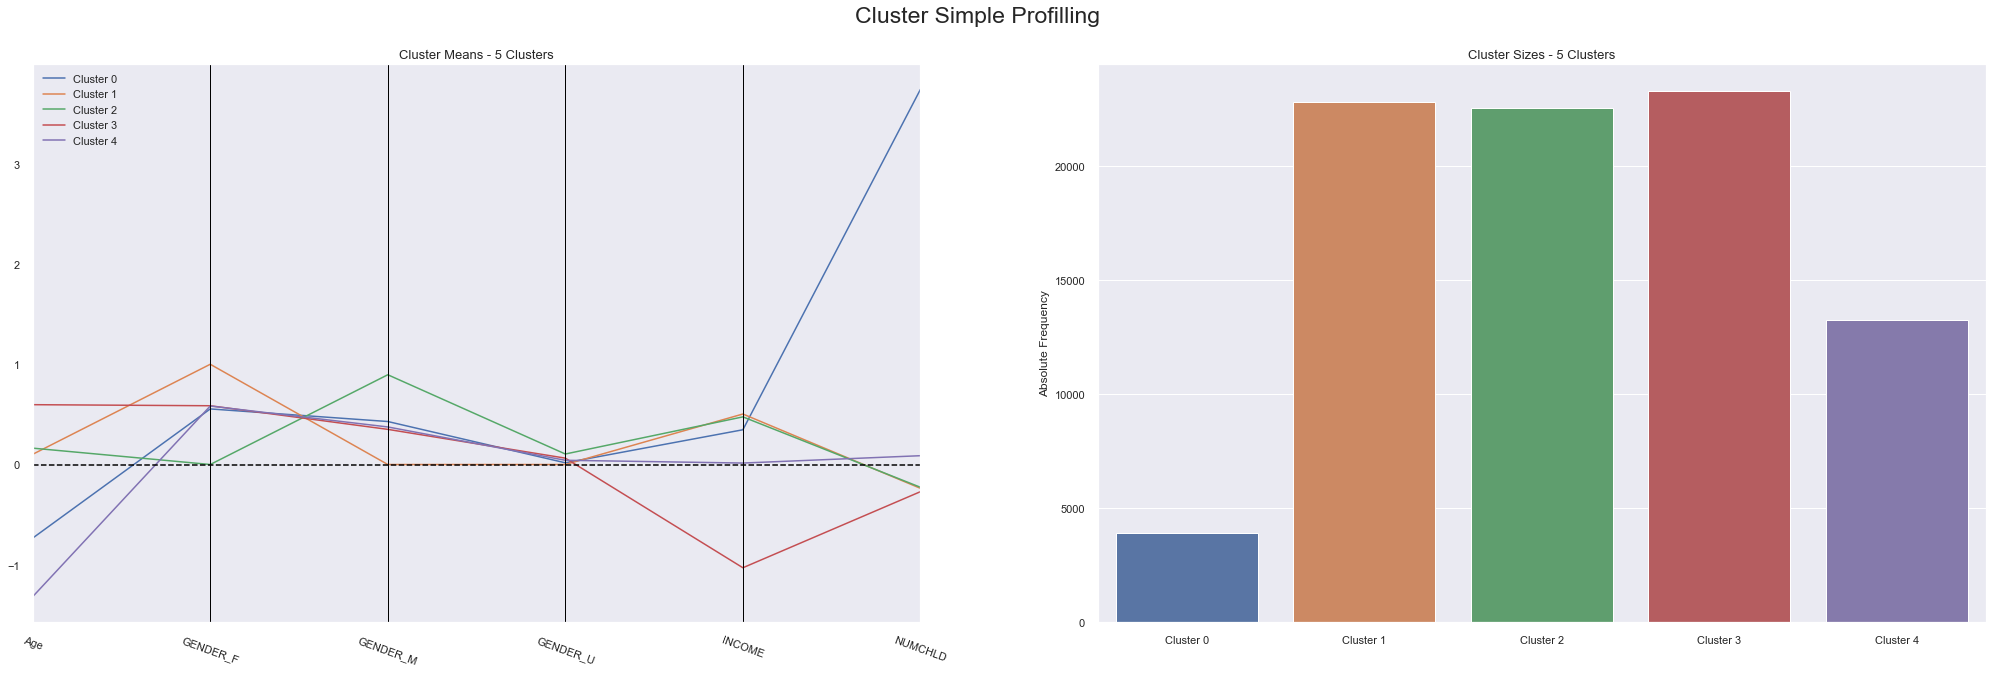

In [57]:
cluster_profiles(km_DEMO, ["km_labels"],(35,10), compar_titles=None)

# 5.GMM

### 5.1.Choosing the type of covariance

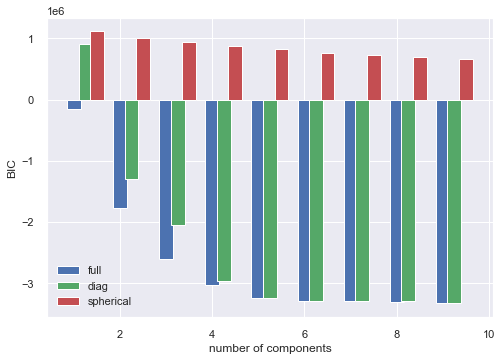

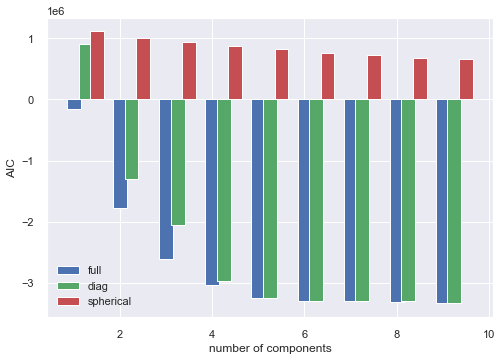

In [58]:
gmm_config(DEMO,10)

In [ ]:
#For the most part, the number of components the model with the lowest AIC and BIC is 'full' 

### 5.2.Find the number of components

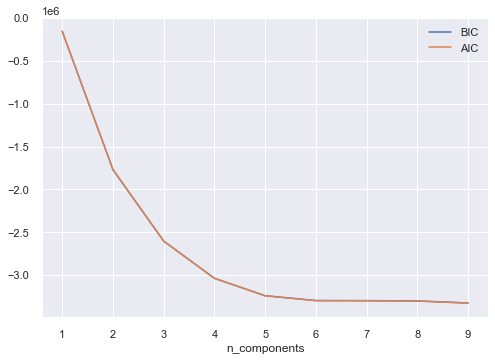

In [59]:
gmm_components(DEMO,'full',1,10)

In [15]:
#According to the graph, the teams considers the optimal number of components is 3.

### 5.3.Applying the clustering

In [60]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(DEMO)
# Concatenating the labels to df
df_concat = pd.concat([DEMO, pd.Series(gmm_labels, index=DEMO.index, name="gmm_labels")], axis=1)
df_concat.head()

,Age,GENDER_F,GENDER_M,GENDER_U,INCOME,NUMCHLD,gmm_labels
0,0.039357,1,0,0,-0.265780,-0.336116,2
1,0.061957,0,1,0,-0.477775,-0.336116,0
2,0.637259,1,0,0,-1.555973,-0.336116,2
3,-0.240152,0,0,1,-0.051029,-0.336116,0
4,-1.276027,1,0,0,0.061324,1.358619,1


In [61]:
gmm_DEMO = DEMO.copy()
gmm_DEMO["gmm_labels"] = gmm_labels

### 5.4.Cluster Profilling

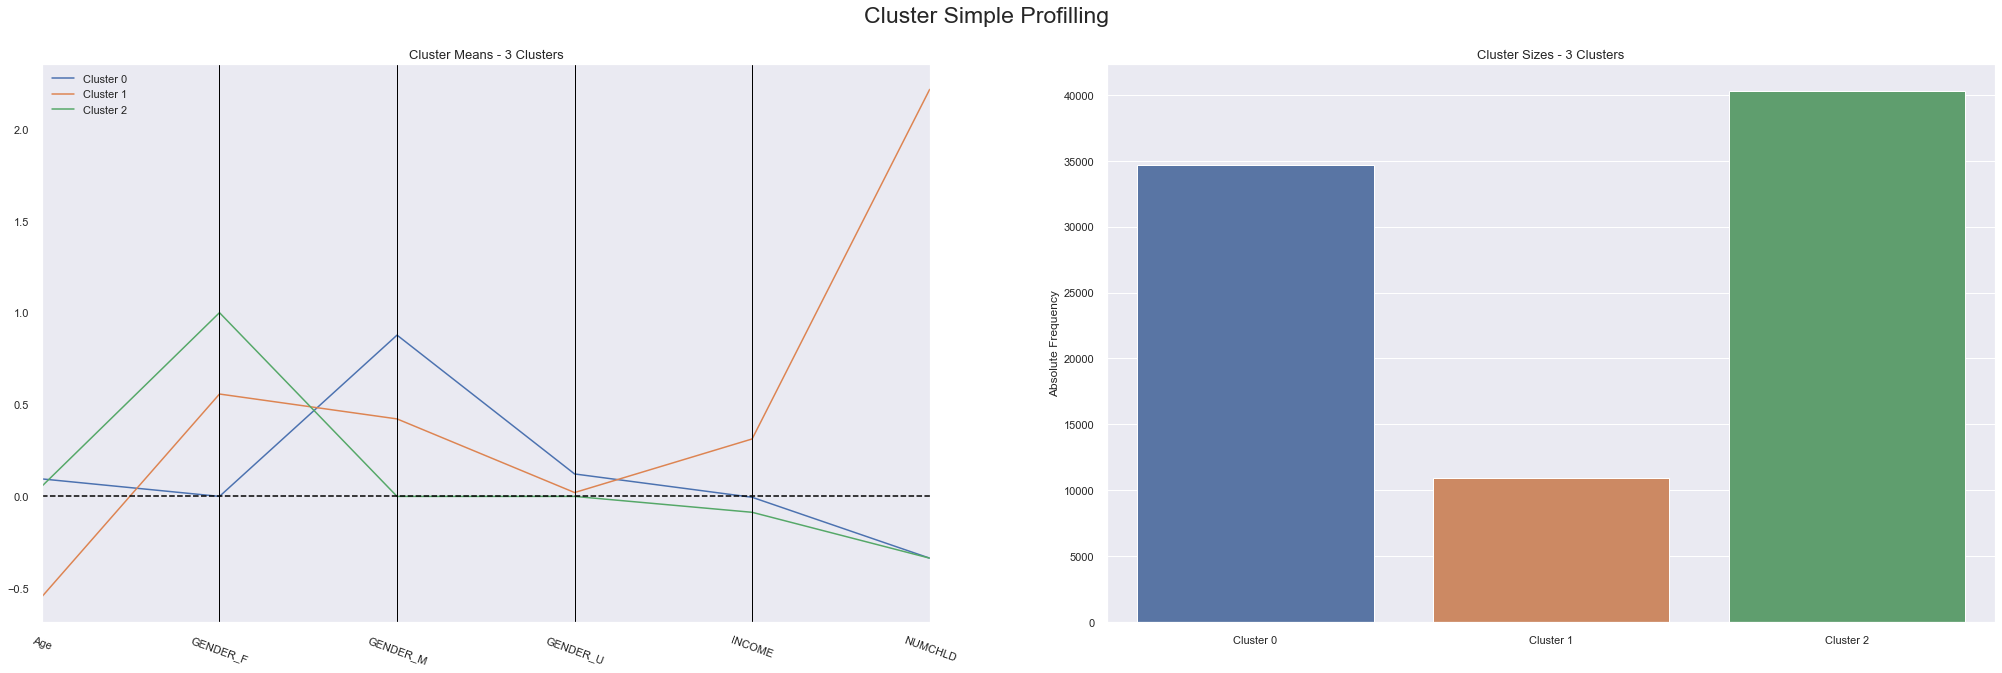

In [62]:
cluster_profiles(gmm_DEMO, ["gmm_labels"], (35,10) , compar_titles=None)

# 6.SOM

### 6.1.Clustering with SOMs: K-means SOM and  Hierarchical Clustering SOM

In [63]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm = sompy.SOMFactory().build(
    DEMO.values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)


 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  2.624000, quantization error: 1.246929

 epoch: 2 ---> elapsed time:  2.951000, quantization error: 2.258767

 epoch: 3 ---> elapsed time:  3.292000, quantization error: 2.224785

 epoch: 4 ---> elapsed time:  3.064000, quantization error: 2.213449

 epoch: 5 ---> elapsed time:  3.462000, quantization error: 2.210508

 epoch: 6 ---> elapsed time:  3.199000, quantization error: 2.206991

 epoch: 7 ---> elapsed time:  3.459000, quantization error: 2.200708

 epoch: 8 ---> elapsed time:  3.307000, quantization error: 2.192844

 epoch: 9 ---> elapsed time:  3.777000, quantization error: 2.186266

 epoch: 10 ---> elapsed time:  3.776000, quantization error: 2.182689

 epoch: 11 ---> elapsed time:  3.559000, quantization error: 2.180334

 epoch: 12 ---> elapsed time:  3.652000, quantization error: 2.178555

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  4.131000, quantization error: 1.404146

 epoch: 15 ---> elapsed time:  3.979000, quantization error: 1.395531

 epoch: 16 ---> elapsed time:  3.831000, quantization error: 1.386870

 epoch: 17 ---> elapsed time:  3.901000, quantization error: 1.378224

 epoch: 18 ---> elapsed time:  3.803000, quantization error: 1.369389

 epoch: 19 ---> elapsed time:  4.130000, quantization error: 1.360544

 epoch: 20 ---> elapsed time:  4.832000, quantization error: 1.351673

 epoch: 21 ---> elapsed time:  4.174000, quantization error: 1.342610

 epoch: 22 ---> elapsed time:  4.046000, quantization error: 1.333278

 epoch: 23 ---> elapsed time:  4.608000, quantization error: 1.323561

 epoch: 24 ---> elapsed time:  4.077000, quantization error: 1.313407

 epoch: 25 ---> elapsed time:  4.358000, quantization error: 1.303203

 epoch: 26 ---> elapsed time:  4.177000, quantization error: 1.292024

 epoch: 27 ---> elapsed time:  4.000000, quantization error: 1.280123

 epoch

In [64]:
# Coordinates of the units in the input space
som_units=sm.get_node_vectors()

C:\Users\Antonio\Anaconda3\envs\classdatamining\lib\site-packages\sompy\visualization\plot_tools.py:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(shape[0], shape[1], comp + 1, aspect='equal')


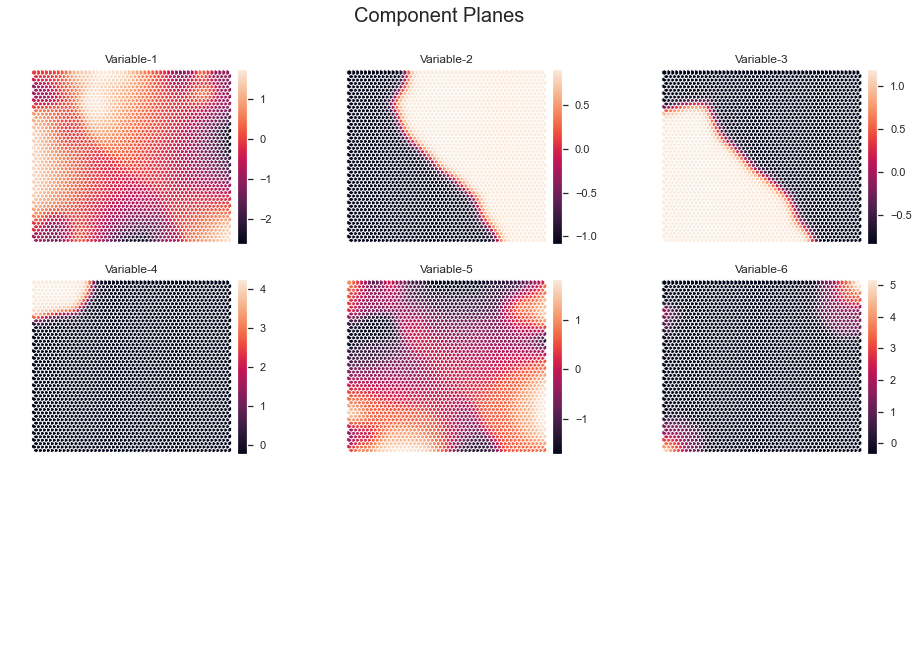

In [65]:
# Component planes on the 50x50 grid
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

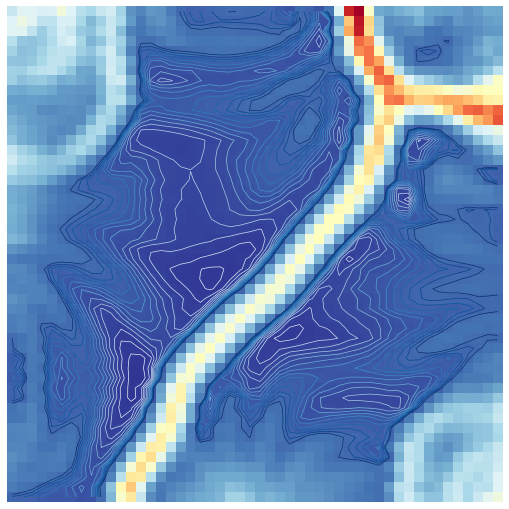

In [66]:
# U-matrix of the 50x50 grid
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance2=1, 
    row_normalized=False, 
    show_data=False, 
    contooor=True # Visualize isomorphic curves
)

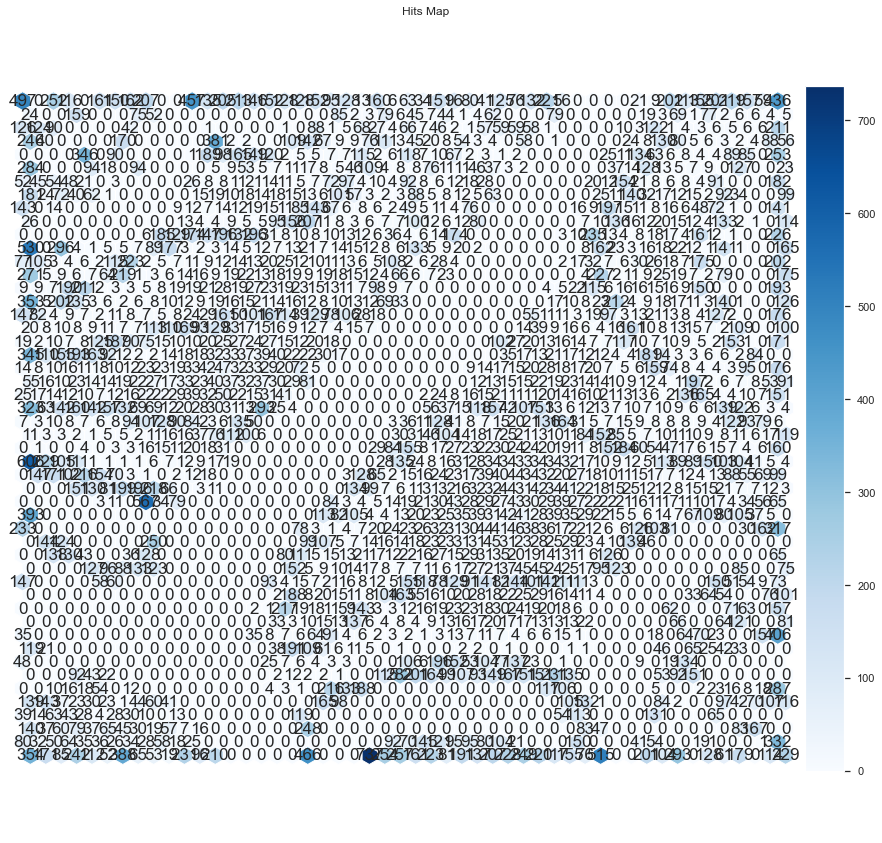

In [67]:
#HIT-MAP
vhts  = BmuHitsView(15,15,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=17, cmap="Blues")
plt.show()

### 6.1.K-Means on top of SOM units

#### 6.1.1.Number of clusters 

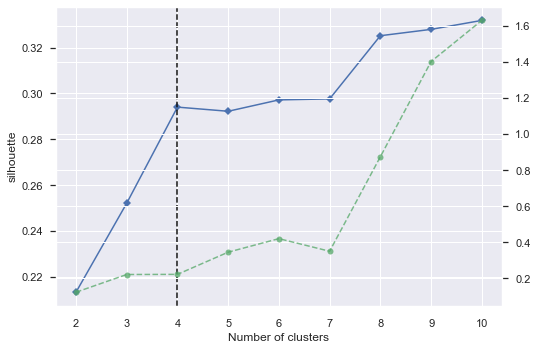

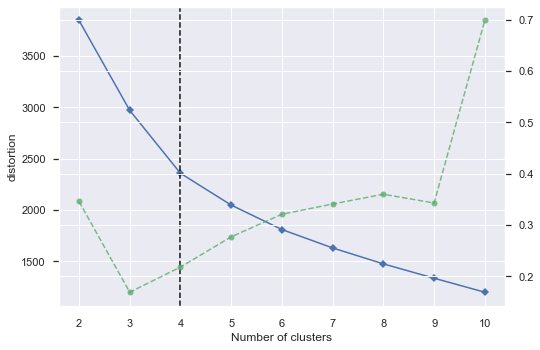

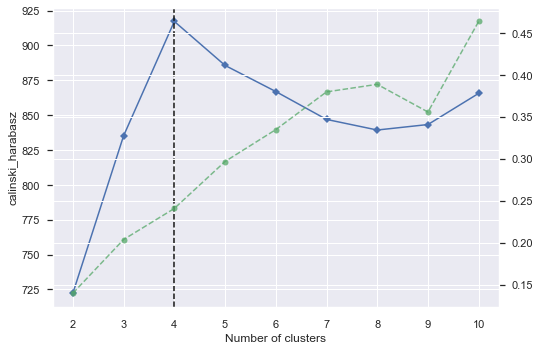

In [68]:
number_clusters(som_units,KMeans( init='k-means++', n_init=15, random_state=1))

#### 6.1.2.Silhouette Analysis 

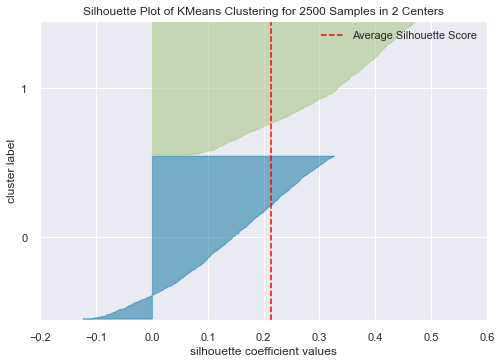

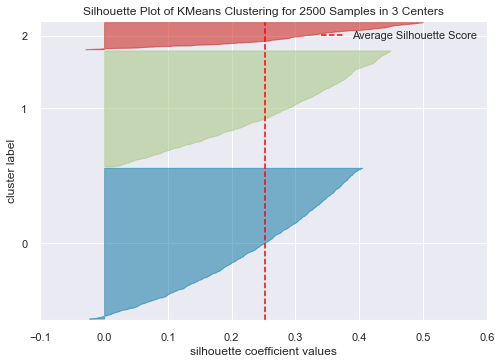

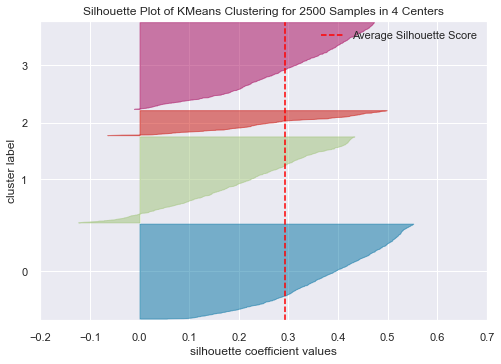

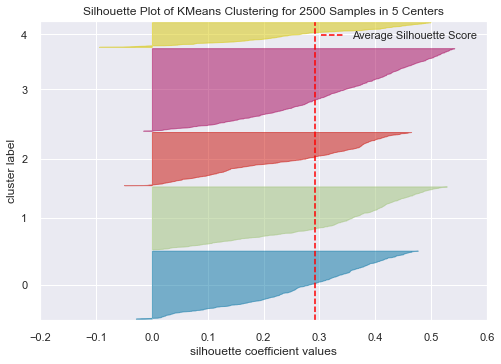

[<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2500 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
 <AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2500 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
 <AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2500 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
 <AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2500 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>]

In [69]:
[SilhouetteVisualizer(KMeans(n_clusters=i,init='k-means++', n_init=15, random_state=1), colors='yellowbrick').fit(som_units).show() for i in range(2,6)]

#### 6.1.3.Apply the clustering 

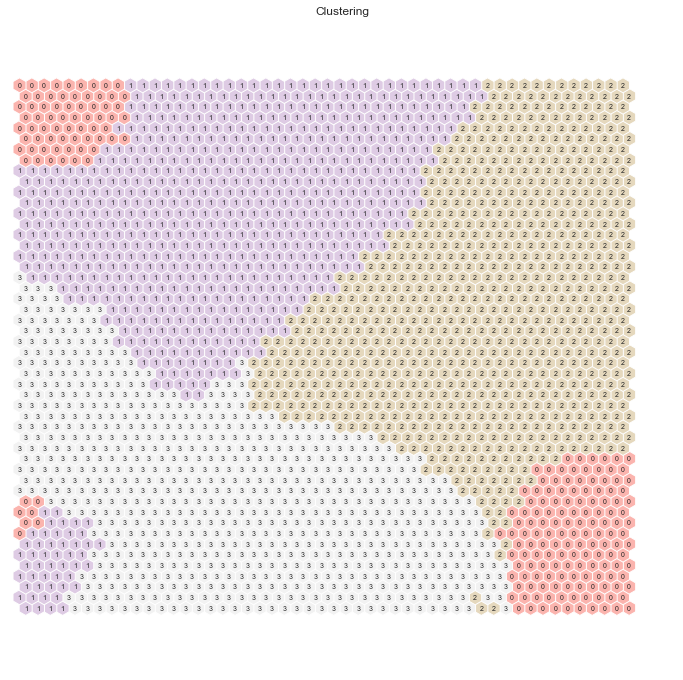

In [70]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
nodeclus_labels_KM = sm.cluster(kmeans)

hits  = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [71]:
DEMO_nodes_KM = pd.DataFrame(som_units)
DEMO_nodes_KM['label'] = nodeclus_labels_KM
DEMO_nodes_KM

,0,1,2,3,4,5,label
0,-0.916586,9.971045e-01,-1.214570e-07,2.895576e-03,0.168249,5.060027,0
1,-0.911774,9.983574e-01,-1.214570e-07,1.642574e-03,-0.078416,4.551579,0
2,-0.902331,9.990650e-01,-1.214570e-07,9.346259e-04,-0.229236,3.858312,0
3,-0.876062,9.996506e-01,-1.214570e-07,3.494034e-04,-0.494807,3.281562,0
4,-0.450602,9.998171e-01,-1.214570e-07,1.831798e-04,-0.624084,2.995751,0
...,...,...,...,...,...,...,...
2495,-1.068516,2.190101e-09,1.000000e+00,8.977132e-08,0.838522,2.313075,0
2496,-1.022843,2.190101e-09,1.000000e+00,8.977132e-08,0.821542,2.907259,0
2497,-0.837249,2.190101e-09,1.000000e+00,8.977132e-08,0.874456,3.260214,0
2498,-0.800558,2.190101e-09,1.000000e+00,8.977132e-08,0.595755,3.888770,0


In [72]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(DEMO)[0]  # get bmus for each observation in df

DEMO_bmus = pd.DataFrame(
    np.concatenate((DEMO, np.expand_dims(bmus_map,1)), axis=1),
    index=DEMO.index, columns=np.append(DEMO.columns,"BMU")
)
DEMO_bmus

,Age,GENDER_F,GENDER_M,GENDER_U,INCOME,NUMCHLD,BMU
0,0.039357,1.0,0.0,0.0,-0.265780,-0.336116,1278.0
1,0.061957,0.0,1.0,0.0,-0.477775,-0.336116,1132.0
2,0.637259,1.0,0.0,0.0,-1.555973,-0.336116,172.0
3,-0.240152,0.0,0.0,1.0,-0.051029,-0.336116,1573.0
4,-1.276027,1.0,0.0,0.0,0.061324,1.358619,653.0
...,...,...,...,...,...,...,...
85865,-0.183048,0.0,1.0,0.0,-0.017895,-0.336116,1427.0
85866,-0.678125,0.0,1.0,0.0,1.678621,1.358619,2492.0
85867,0.039357,0.0,1.0,0.0,-0.357898,-0.336116,1132.0
85868,-0.140014,1.0,0.0,0.0,1.678621,-0.336116,1852.0


In [73]:
# Get cluster labels for each observation
DEMO_final_KMSOM =DEMO_bmus.merge(DEMO_nodes_KM['label'], 'left', left_on="BMU", right_index=True)
DEMO_final_KMSOM

,Age,GENDER_F,GENDER_M,GENDER_U,INCOME,NUMCHLD,BMU,label
0,0.039357,1.0,0.0,0.0,-0.265780,-0.336116,1278.0,2
1,0.061957,0.0,1.0,0.0,-0.477775,-0.336116,1132.0,1
2,0.637259,1.0,0.0,0.0,-1.555973,-0.336116,172.0,3
3,-0.240152,0.0,0.0,1.0,-0.051029,-0.336116,1573.0,2
4,-1.276027,1.0,0.0,0.0,0.061324,1.358619,653.0,0
...,...,...,...,...,...,...,...,...
85865,-0.183048,0.0,1.0,0.0,-0.017895,-0.336116,1427.0,1
85866,-0.678125,0.0,1.0,0.0,1.678621,1.358619,2492.0,0
85867,0.039357,0.0,1.0,0.0,-0.357898,-0.336116,1132.0,1
85868,-0.140014,1.0,0.0,0.0,1.678621,-0.336116,1852.0,2


In [74]:
# Characterizing the final clusters
DEMO_final_KMSOM.drop(columns='BMU').groupby('label').mean()

,Age,GENDER_F,GENDER_M,GENDER_U,INCOME,NUMCHLD
label,,,,,,
0,-0.585233,0.577486,0.404709,0.017804,0.336803,2.251651
1,-0.193053,0.000000,0.995326,0.004674,0.382087,-0.319234
2,-0.260065,0.939224,0.000000,0.060776,0.374103,-0.333535
3,0.659008,0.532493,0.372914,0.094594,-0.862164,-0.322756


#### 6.1.4.Cluster Profiles

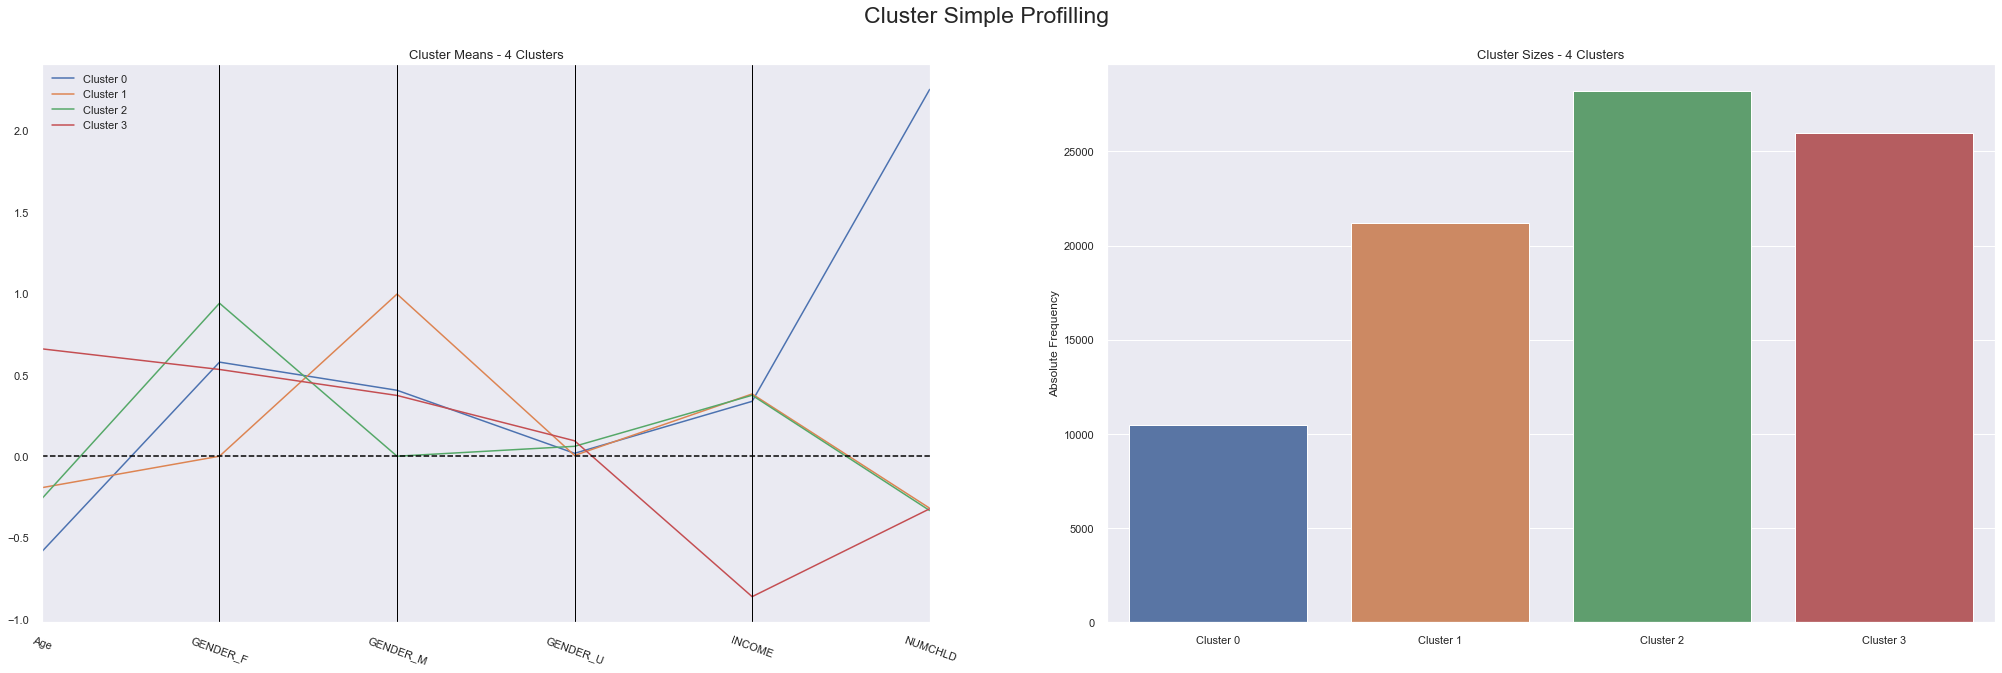

In [75]:
cluster_profiles(DEMO_final_KMSOM.drop('BMU',axis=1), ["label"], (35,10), compar_titles=None)


### 6.2.Hierarchical Clustering on top of SOM units

#### 6.2.1.R2 plot

NumExpr defaulting to 4 threads.


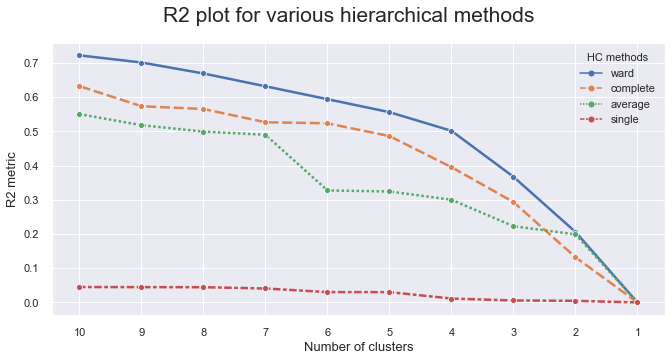

In [76]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(df=pd.DataFrame(som_units), link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

#### 6.2.2.Dendrogram

In [77]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(pd.DataFrame(som_units))

array([1511, 2479, 1267, ...,    5,    2,    0], dtype=int64)

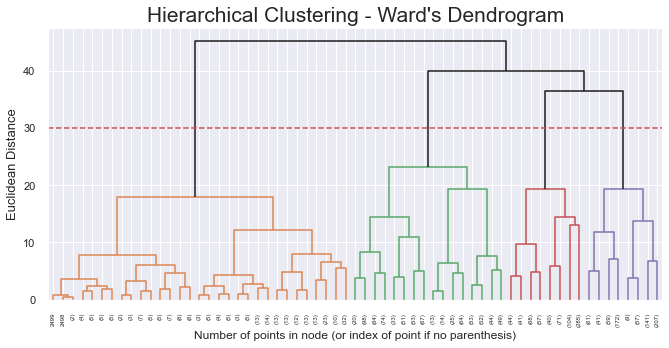

In [78]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# setting the threshold
y_threshold = 30
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

#### 6.2.3.K-elbow plots

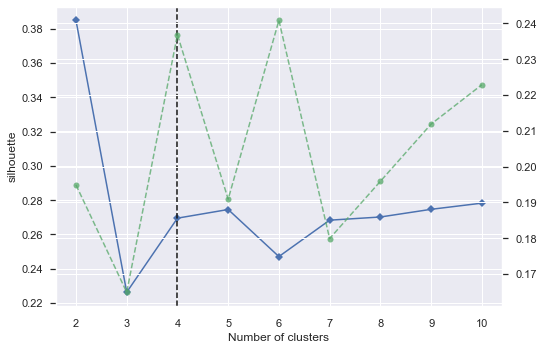

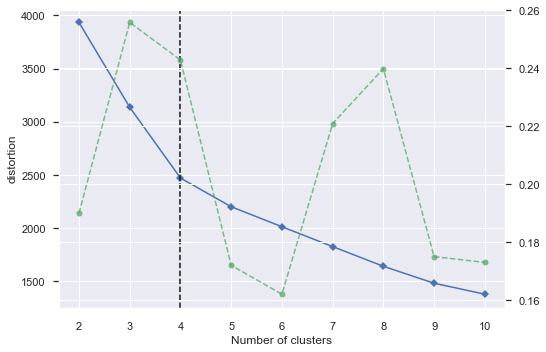

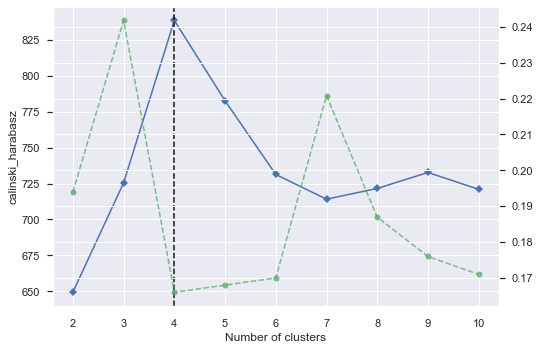

In [79]:
number_clusters(som_units, AgglomerativeClustering(linkage=linkage))

#### 6.2.4.Applying the Clustering

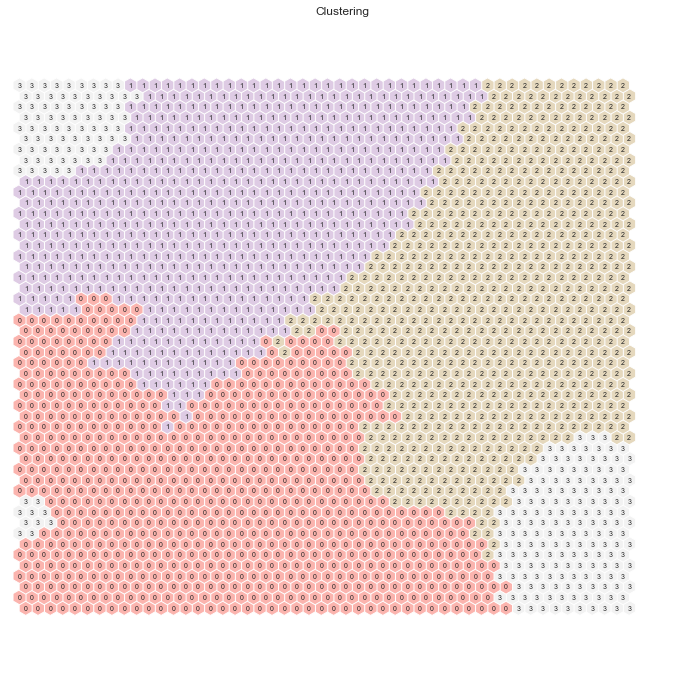

In [80]:
# Perform Hierarchical clustering on top of the 2500 untis (sm.get_node_vectors() output)
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels_HC= sm.cluster(hierclust)

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [81]:
# Check the nodes and and respective clusters
nodes = sm.get_node_vectors()

DEMO_nodes_HC = pd.DataFrame(nodes)
DEMO_nodes_HC['label'] = nodeclus_labels_HC
DEMO_nodes_HC

,0,1,2,3,4,5,label
0,-0.916586,9.971045e-01,-1.214570e-07,2.895576e-03,0.168249,5.060027,3
1,-0.911774,9.983574e-01,-1.214570e-07,1.642574e-03,-0.078416,4.551579,3
2,-0.902331,9.990650e-01,-1.214570e-07,9.346259e-04,-0.229236,3.858312,3
3,-0.876062,9.996506e-01,-1.214570e-07,3.494034e-04,-0.494807,3.281562,3
4,-0.450602,9.998171e-01,-1.214570e-07,1.831798e-04,-0.624084,2.995751,3
...,...,...,...,...,...,...,...
2495,-1.068516,2.190101e-09,1.000000e+00,8.977132e-08,0.838522,2.313075,3
2496,-1.022843,2.190101e-09,1.000000e+00,8.977132e-08,0.821542,2.907259,3
2497,-0.837249,2.190101e-09,1.000000e+00,8.977132e-08,0.874456,3.260214,3
2498,-0.800558,2.190101e-09,1.000000e+00,8.977132e-08,0.595755,3.888770,3


In [82]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(DEMO)[0]  # get bmus for each observation in df

DEMO_bmus = pd.DataFrame(
    np.concatenate((DEMO, np.expand_dims(bmus_map,1)), axis=1),
    index=DEMO.index, columns=np.append(DEMO.columns,"BMU")
)
DEMO_bmus

,Age,GENDER_F,GENDER_M,GENDER_U,INCOME,NUMCHLD,BMU
0,0.039357,1.0,0.0,0.0,-0.265780,-0.336116,1278.0
1,0.061957,0.0,1.0,0.0,-0.477775,-0.336116,1132.0
2,0.637259,1.0,0.0,0.0,-1.555973,-0.336116,172.0
3,-0.240152,0.0,0.0,1.0,-0.051029,-0.336116,1573.0
4,-1.276027,1.0,0.0,0.0,0.061324,1.358619,653.0
...,...,...,...,...,...,...,...
85865,-0.183048,0.0,1.0,0.0,-0.017895,-0.336116,1427.0
85866,-0.678125,0.0,1.0,0.0,1.678621,1.358619,2492.0
85867,0.039357,0.0,1.0,0.0,-0.357898,-0.336116,1132.0
85868,-0.140014,1.0,0.0,0.0,1.678621,-0.336116,1852.0


In [83]:
# Get cluster labels for each observation
DEMO_final_HC = DEMO_bmus.merge(DEMO_nodes_HC['label'], 'left', left_on="BMU", right_index=True)
DEMO_final_HC

,Age,GENDER_F,GENDER_M,GENDER_U,INCOME,NUMCHLD,BMU,label
0,0.039357,1.0,0.0,0.0,-0.265780,-0.336116,1278.0,2
1,0.061957,0.0,1.0,0.0,-0.477775,-0.336116,1132.0,1
2,0.637259,1.0,0.0,0.0,-1.555973,-0.336116,172.0,0
3,-0.240152,0.0,0.0,1.0,-0.051029,-0.336116,1573.0,1
4,-1.276027,1.0,0.0,0.0,0.061324,1.358619,653.0,3
...,...,...,...,...,...,...,...,...
85865,-0.183048,0.0,1.0,0.0,-0.017895,-0.336116,1427.0,1
85866,-0.678125,0.0,1.0,0.0,1.678621,1.358619,2492.0,3
85867,0.039357,0.0,1.0,0.0,-0.357898,-0.336116,1132.0,1
85868,-0.140014,1.0,0.0,0.0,1.678621,-0.336116,1852.0,2


In [84]:
# Characterizing the final clusters
DEMO_final_HC.drop(columns='BMU').groupby('label').mean()

,Age,GENDER_F,GENDER_M,GENDER_U,INCOME,NUMCHLD
label,,,,,,
0,0.611947,0.558737,0.348591,0.092672,-0.862194,-0.323060
1,-0.177241,0.000000,0.945212,0.054788,0.366586,-0.332963
2,-0.254303,0.978101,0.000000,0.021899,0.414994,-0.336116
3,-0.569843,0.570115,0.412240,0.017646,0.339597,2.235096


#### 6.2.5.Cluster Profiles

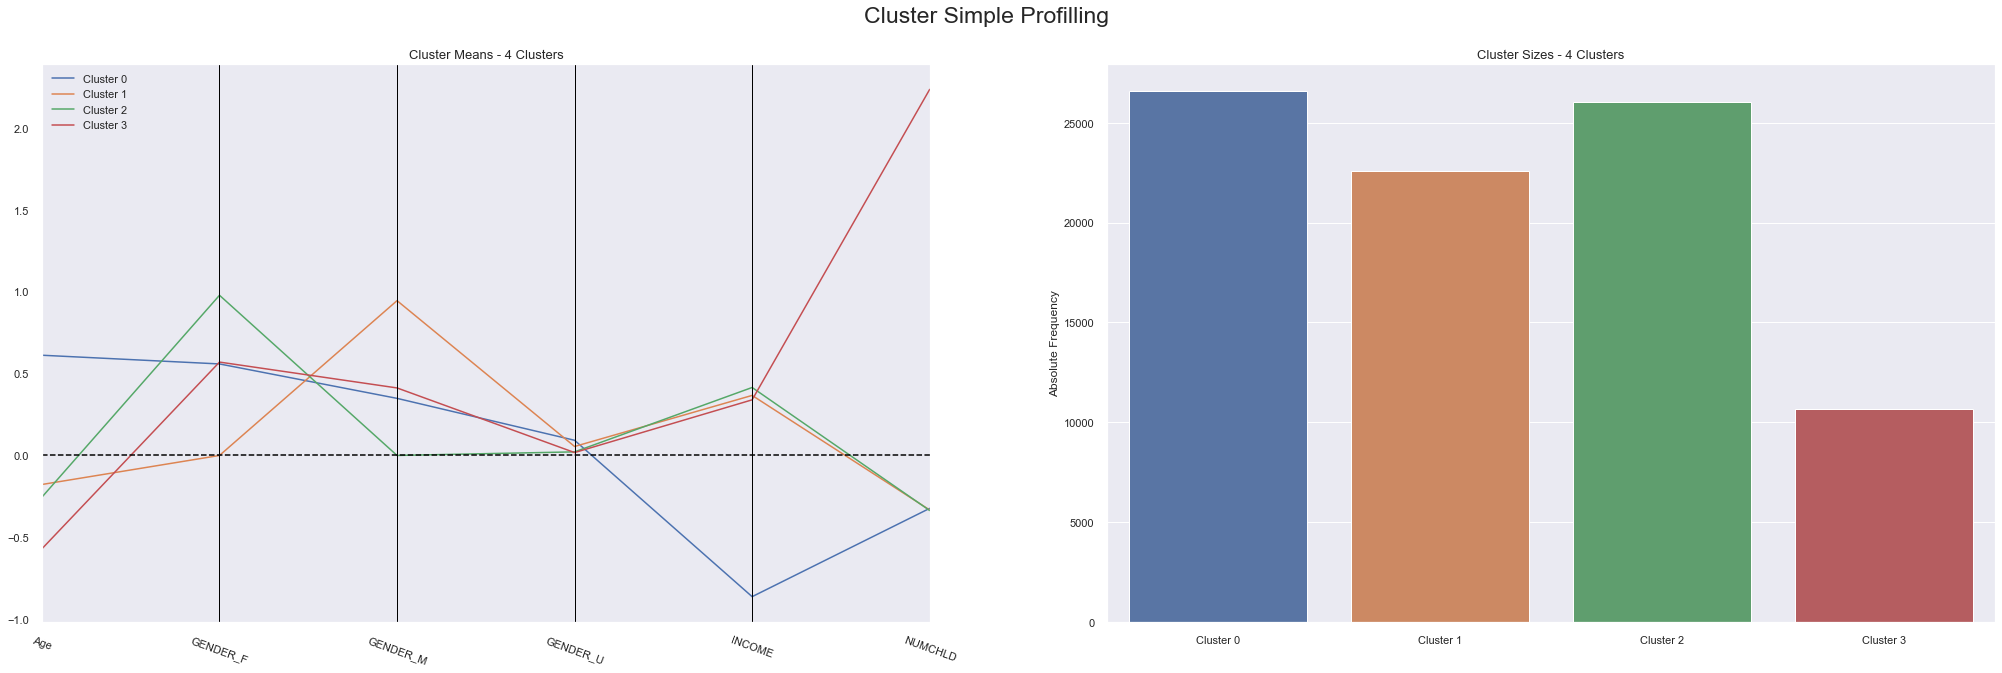

In [85]:
cluster_profiles(DEMO_final_HC.drop('BMU',axis=1), ["label"], (35,10), compar_titles=None)

In [86]:
#creating a csv file to afterwards import to the merging notebook.
DEMO_final_HC.to_csv('Demo(HC+SOM).csv',sep=';',index=False)